In [97]:
from sklearn.preprocessing import scale,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.decomposition import PCA
import os 


def plot_feature_importance(model,df):
    # Get feature importances
    feature_importances = model.feature_importances_

    # Associate feature importances with feature names
    feature_names = df.columns.values[:-1]
    feature_importance_dict = dict(zip(feature_names, feature_importances))

    # Print feature importance scores
    for feature, importance in feature_importance_dict.items():
        print(f"{feature}: {importance:.4f}")

    # Plot feature importances
    plt.figure(figsize=(8, 6))
    plt.bar(feature_importance_dict.keys(), feature_importance_dict.values())
    plt.xticks(rotation=45)
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.title("Feature Importance from Random Forest")
    plt.tight_layout()
    plt.show()

def get_abs(y,y_pred):
    return abs(y-y_pred)


def get_starting_idx(df):
    
    df['10_temp_diff'] = df['temperature'] - df['temperature'].shift(-10)

    df['temp_diff'] =  df['temperature'] - df['temperature'].shift(-1)

    for (idx, temp_diff) in enumerate(df['10_temp_diff']):

        if abs(temp_diff) >=1.5:

            new_df = df.iloc[idx:]

            return new_df[['temperature','date','Preproduct','Feed','Drilling Depth','10_temp_diff','temp_diff','RPM','audio']].dropna()
        
    return pd.DataFrame()
    

def separate_layers(start_df):

            
    try:

        layer1_thickness = int(start_df['Preproduct'].to_list()[0].split('_')[0].split('x')[-1])
        layer2_thickness = int(start_df['Preproduct'].to_list()[0].split('_')[1].split('x')[-1])
        layer3_thickness = int(start_df['Preproduct'].to_list()[0].split('_')[2].split('x')[-1])

        layer_1_duration = layer1_thickness/start_df['Feed'].iloc[0]
        layer_2_duration = layer2_thickness/start_df['Feed'].iloc[0]
        layer_3_duration = layer3_thickness/start_df['Feed'].iloc[0]
        
        
        
        layer_4_duration = (start_df['Drilling Depth'].iloc[0] - (layer1_thickness + layer2_thickness + layer3_thickness)) / start_df['Feed'].iloc[0] # I calculated the last thicknes and find the duration
        
        if layer_4_duration < 0:
            return pd.DataFrame()

        l1_dp = round(layer_1_duration * 10)
        l2_dp = round(layer_2_duration * 10)
        l3_dp = round(layer_3_duration * 10)
        l4_dp = round(layer_4_duration * 10)
        
        
        
        
        l1 = ['layer1' for _ in range(l1_dp)]
        l2 = ['layer2' for _ in range(l2_dp)]
        l3=  ['layer3' for _ in range(l3_dp)]
        l4 = ['layer4' for _ in range(l4_dp)]

        l = l1 + l2 + l3 + l4

        layers_DF = pd.DataFrame({'layers':l}) # this will give all the output of the layer separation
        
        start_df = pd.concat([start_df.reset_index(),layers_DF],axis=1)
        
        start_df = start_df.dropna()


        return start_df[['temperature','date','Preproduct','Feed','Drilling Depth','10_temp_diff','temp_diff','layers','RPM','audio']]
    
    except Exception as e:
        print("error {} when processing layers...skipping...".format(str(e)))

        return pd.DataFrame()

        

def separate_product(df):
    
    l1,l2,l3,l4 = df['Preproduct'].iloc[0].split('_')

    l1_df = df[df['layers']=='layer1'][['temperature','date','Feed','Drilling Depth','10_temp_diff','temp_diff','layers','RPM','audio']]
    l2_df = df[df['layers']=='layer2'][['temperature','date','Feed','Drilling Depth','10_temp_diff','temp_diff','layers','RPM','audio']]
    
    l3_df = df[df['layers']=='layer3'][['temperature','date','Feed','Drilling Depth','10_temp_diff','temp_diff','layers','RPM','audio']]
    l4_df = df[df['layers']=='layer4'][['temperature','date','Feed','Drilling Depth','10_temp_diff','temp_diff','layers','RPM','audio']]
    
    l1_df['Preproduct'] = l1
    l2_df['Preproduct'] = l2
    l3_df['Preproduct'] = l3
    l4_df['Preproduct'] = l4
    
    new_df = pd.concat([l1_df,l2_df,l3_df,l4_df],axis=0)

    return new_df




def process_whole_data(folder_path,saved_folder):
    
    if not os.path.exists(saved_folder):
        os.mkdir(saved_folder)

    files = os.listdir(folder_path)
    for file in files:
        
        try:

            file_folder = os.path.join(folder_path,file)

            df_cfg = pd.read_csv(os.path.join(file_folder,'config.csv'))
            df = pd.read_parquet(os.path.join(file_folder,'data.parquet'))
            
            
            df['Preproduct'] = df_cfg['Preproduct'].values[0]

            df['Feed'] = df_cfg['Feed'].values[0]
            df['Drilling Depth'] = df_cfg['Drilling Depth'].values[0]
            
            df['RPM'] = df_cfg['RPM'].values[0]
            df['audio'] = df['audio'].shift(-1)
            df = df[['temperature','date','Preproduct','Feed','Drilling Depth','RPM','audio']]
            df = df.dropna()
            
            
            if len(df) > 0:
                new_df = get_starting_idx(df)
                
                if len(new_df) > 0:
                    
                    new_df = separate_layers(new_df)

                    if len(new_df) > 0:
                        new_df = separate_product(new_df)
                        new_df.to_csv(f'{saved_folder}/{file}.csv')
                        
        
        except Exception as e:
            
            print("error {} processing file. skipping...".format(e))
        

def gen_label(df):
    labels = []

    for i in range(len(df)):
        d, t = df.iloc[i]['Preproduct'].split("x")

        if d!='spong':
            get = d.split(',')
            if len(get) > 1:
                labels.append(0.54)
            elif int(get[0])==50:
                labels.append(0.40)
            elif int(get[0])==35:
                labels.append(0.29)
            elif int(get[0])==30:
                labels.append(0.25)
            elif int(get[0])==20:
                labels.append(0.22)
            elif int(get[0])==15:
                labels.append(0.19)
        else:
            labels.append(0.60)

    return df, labels


def process_data_for_training(file):

    df = pd.read_csv(file)
    
    audio = df['audio'].apply(lambda x: ast.literal_eval(x[2:-1]))

    maxlen = np.max(audio.apply(len))
    audio_padded= audio.apply(lambda x: np.pad(x, (0, maxlen - len(x)), mode='constant'))
    audio_2d = np.vstack(audio_padded.values)
    
    _,label = gen_label(df)
    df['label'] = label
    dt=pd.to_datetime(df['date'])
    df['minute'] = dt.dt.minute
    df['second'] = dt.dt.second


    df = df.drop(['date','layers','audio','Preproduct','10_temp_diff'],axis=1)

    X = df.drop(['label'],axis=1).values
    Y = df['label'].values

    return X,Y, audio_2d,dt


def find_last_index(x):
    edge_indices = []
    current_value = None
    
    for i in range(len(x) - 1, -1, -1):
        if x[i] != current_value:
            edge_indices.append(i)
            current_value = x[i]
    
    return edge_indices[::-1]

In [114]:
import torch.nn as nn
from torch.utils.data import DataLoader
import torch
from sklearn.metrics import accuracy_score

class load_ds():
    def __init__(self,folder_path):
        self.folder_path = folder_path
        self.datas = os.listdir(folder_path)

    def __getitem__(self,idx):
        X,Y,_,_ = process_data_for_training(f"{self.folder_path}/{self.datas[idx]}")
        X = scale(X)

        return torch.FloatTensor(X), torch.tensor(Y)

    def __len__(self):
        return len(self.datas)
    
    def collate_fn(self,batch):
        X = []
        Y = []

        for data in batch:
            x, y = data
            X.append(x)
            Y.append(y)
        
        X = torch.nn.utils.rnn.pad_sequence(X,batch_first=True,padding_value=0)
        Y = torch.nn.utils.rnn.pad_sequence(Y, batch_first=True,padding_value=0)

        return X, Y
    
class LSTMCell(nn.Module):
    def __init__(self,hidden_dim, input_size,n_out=7):
        super(LSTMCell,self).__init__()
        self.lstm = nn.LSTMCell(input_size=input_size,hidden_size=hidden_dim)
        self.proj_layer = nn.Linear(hidden_dim,n_out)
        self.dropout = nn.Dropout(0.1)
        self.hidden_dim = hidden_dim
        self.loss_fn = nn.MSELoss()

    def forward(self,x,y=None):
        self.init_layers(x)

        outputs = []
        for i in range(x.shape[1]):
            self.hidden_state, self.cell_state = self.lstm(x[:,i,:],(self.hidden_state,self.cell_state))
            output = self.proj_layer(self.hidden_state)
            outputs.append(output)
        
        outputs = torch.stack(outputs,dim=1)
        if y!=None:
            loss = self.loss_fn(outputs.squeeze(-1),y)
            return outputs, loss

        return outputs

    def init_layers(self,x):
        self.hidden_state = x.data.new(x.shape[0],self.hidden_dim).zero_()
        self.cell_state = x.data.new(x.shape[0],self.hidden_dim).zero_()


def train(model,loader,optimizer,epochs,device='cpu'):
    model.train()
    model.to(device)
    all_loss = []
    for epoch in range(epochs):
        losses = []
        for batch in loader:
            x,y = batch
            x = x.to(device).float()
            y = y.to(device).float()
            optimizer.zero_grad()
            _, loss = model(x,y)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        all_loss.append(np.mean(losses))
        print(f"Epoch {epoch}: Loss: {np.mean(losses)}")

def test(model,loader,device='cpu'):
    model.eval()
    model.to(device)
    losses = []
    with torch.no_grad():
        for batch in loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)

            _,loss = model(inputs.squeeze(1),targets)  # Forward pass
            losses.append(loss.item())

        # Print the average loss on the test data
        print(f"Validation Loss: {np.mean(losses)}")

In [115]:
#                                                  RUN THIS
train_ds = load_ds('train_data')
test_ds = load_ds('test_data')
val_ds = load_ds('val_data')
train_loader = DataLoader(train_ds,batch_size=8,shuffle=True,collate_fn=train_ds.collate_fn)
test_loader = DataLoader(test_ds,batch_size=4,shuffle=False,collate_fn=test_ds.collate_fn)
val_loader = DataLoader(val_ds,batch_size=8,shuffle=False,collate_fn=val_ds.collate_fn)

In [116]:
model = LSTMCell(200,8,n_out = 1)
optim = torch.optim.Adam(model.parameters(),lr=0.001)
model.load_state_dict(torch.load('improved_lstm1.pt')['state_dict'])

<All keys matched successfully>

In [117]:
train(model,train_loader,optim,20,device='cuda:0')

Epoch 0: Loss: 0.006071666050154497
Epoch 1: Loss: 0.004403435269041973
Epoch 2: Loss: 0.003460453083629117
Epoch 3: Loss: 0.00382514824570321
Epoch 4: Loss: 0.0036375066128504626
Epoch 5: Loss: 0.004051515791455612
Epoch 6: Loss: 0.004754783667843132
Epoch 7: Loss: 0.00471846414182116
Epoch 8: Loss: 0.0038695304161485504
Epoch 9: Loss: 0.00432439540129374
Epoch 10: Loss: 0.003695377997834893
Epoch 11: Loss: 0.003922045189777718
Epoch 12: Loss: 0.0036613650702159196
Epoch 13: Loss: 0.0035336545517887265
Epoch 14: Loss: 0.0035061180071138285
Epoch 15: Loss: 0.004132859847124885
Epoch 16: Loss: 0.0037533584297360745
Epoch 17: Loss: 0.0035659680759315103
Epoch 18: Loss: 0.0035224925754043985
Epoch 19: Loss: 0.0042240220286390365


In [118]:
#                                                 This is testing Loss
test(model,test_loader,device='cuda:0')

Validation Loss: 0.008300699167577193


In [135]:
checkpoint = {'state_dict':model.state_dict()}
torch.save(checkpoint,'improved_lstm.pt')

In [119]:
#                                                      THIS WILL PLOT PREDICTION
import random
import os

train_path = 'train_data'
test_path = 'test_data'
val_path = 'val_data'

train_data = os.listdir('train_data')
test_data = os.listdir('test_data')
val_data = os.listdir('val_data')

train_randn1 = random.randint(0,len(train_data)-1)
test_randn1 = random.randint(0,len(test_data)-1)
val_randn1 = random.randint(0,len(val_data)-1)



train_x1, train_y1,train_audio1,train_dt1 = process_data_for_training(os.path.join(train_path,train_data[train_randn1]))
test_x1, test_y1, test_audio1, test_dt1 = process_data_for_training(os.path.join(test_path,test_data[test_randn1]))
val_x1, val_y1, val_audio1,val_dt1 = process_data_for_training(os.path.join(val_path,val_data[val_randn1]))

In [120]:
train_x1 = torch.FloatTensor(scale(train_x1)).unsqueeze(0)
train_y1 = torch.FloatTensor(train_y1)


test_x1 = torch.FloatTensor(scale(test_x1)).unsqueeze(0)
test_y1 = torch.FloatTensor(test_y1)

val_x1 = torch.FloatTensor(scale(val_x1)).unsqueeze(0)
val_y1 = torch.FloatTensor(val_y1)

In [121]:
model.to('cpu')
train_out1 = model(train_x1)
test_out1 = model(test_x1)
val_out1  = model(val_x1)

In [122]:
train_out1 = train_out1.squeeze(0).squeeze(-1).data.numpy()
test_out1 = test_out1.squeeze(0).squeeze(-1).data.numpy()
val_out1 = val_out1.squeeze(0).squeeze(-1).data.numpy()

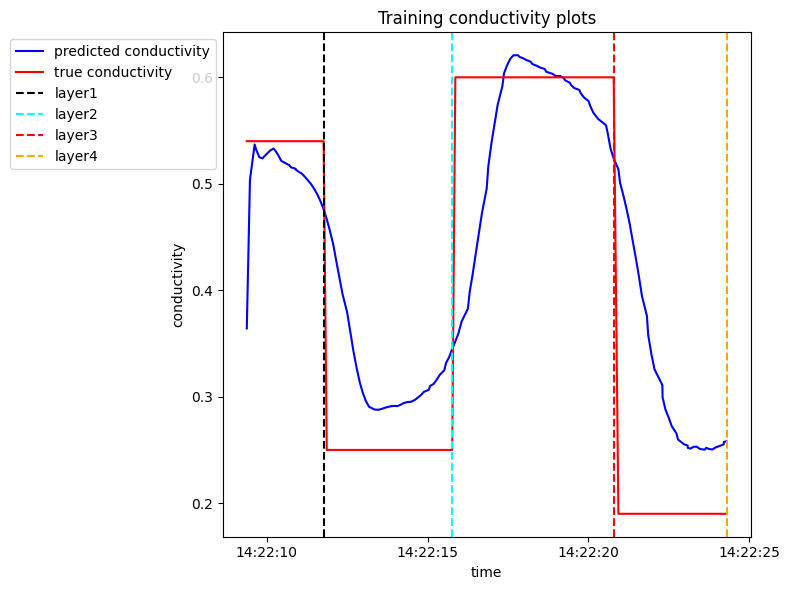

In [123]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(train_dt1,train_out1,label='predicted conductivity', color='blue')
ax.plot(train_dt1,train_y1,label='true conductivity',color='red')

out = find_last_index(train_y1)
ax.axvline(x=train_dt1[out[0]],color='black',linestyle='--', label='layer1')
ax.axvline(x=train_dt1[out[1]],color='cyan',linestyle='--', label='layer2')
ax.axvline(x=train_dt1[out[2]],color='red',linestyle='--', label='layer3')
ax.axvline(x=train_dt1[out[3]],color='orange',linestyle='--', label='layer4')

# Add labels and title
plt.ylabel("conductivity")
plt.xlabel('time')
plt.title("Training conductivity plots")

plt.legend(loc='upper right', bbox_to_anchor=(0.0, 1.0))
plt.tight_layout()
plt.show()


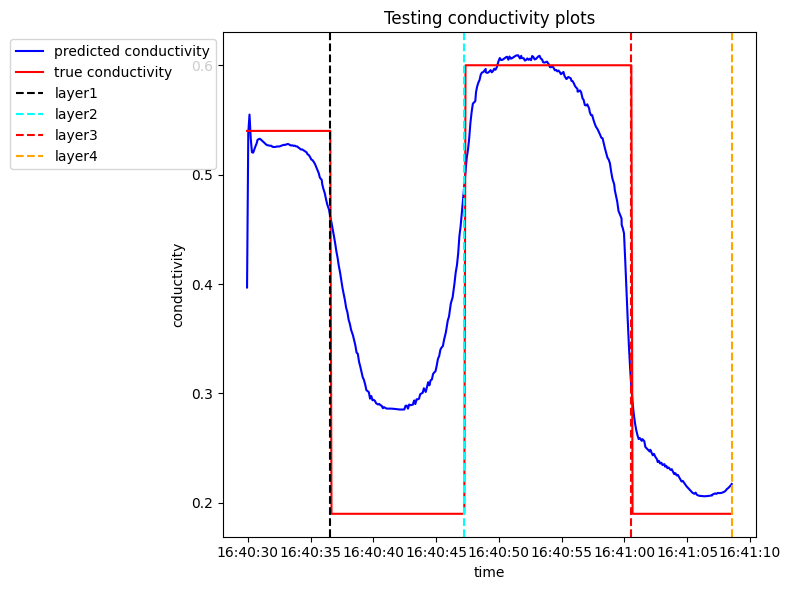

In [124]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(test_dt1,test_out1,label='predicted conductivity', color='blue')
ax.plot(test_dt1,test_y1,label='true conductivity',color='red')

out = find_last_index(test_y1)
ax.axvline(x=test_dt1[out[0]],color='black',linestyle='--', label='layer1')
ax.axvline(x=test_dt1[out[1]],color='cyan',linestyle='--', label='layer2')
ax.axvline(x=test_dt1[out[2]],color='red',linestyle='--', label='layer3')
ax.axvline(x=test_dt1[out[3]],color='orange',linestyle='--', label='layer4')

# Add labels and title
plt.ylabel("conductivity")
plt.xlabel('time')
plt.title("Testing conductivity plots")

plt.legend(loc='upper right', bbox_to_anchor=(0.0, 1.0))
plt.tight_layout()
plt.show()


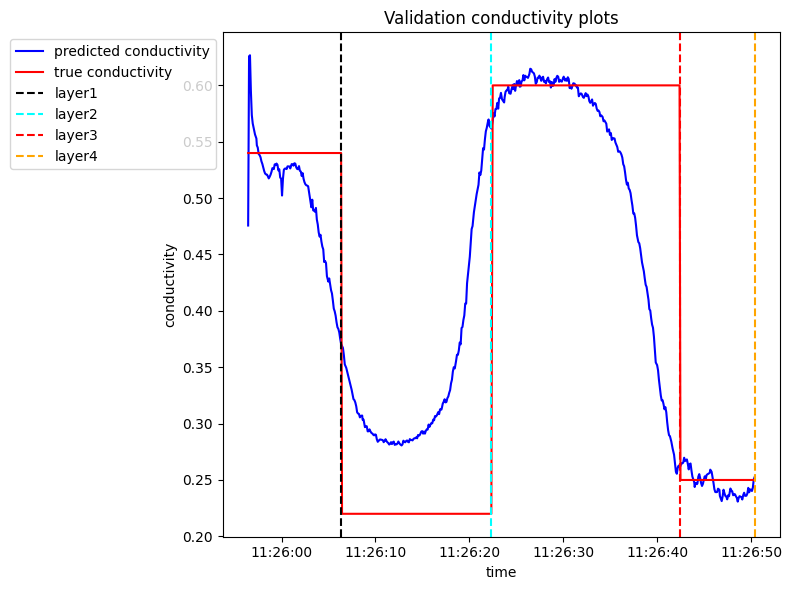

In [125]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(val_dt1,val_out1,label='predicted conductivity', color='blue')
ax.plot(val_dt1,val_y1,label='true conductivity',color='red')

out = find_last_index(val_y1)
ax.axvline(x=val_dt1[out[0]],color='black',linestyle='--', label='layer1')
ax.axvline(x=val_dt1[out[1]],color='cyan',linestyle='--', label='layer2')
ax.axvline(x=val_dt1[out[2]],color='red',linestyle='--', label='layer3')
ax.axvline(x=val_dt1[out[3]],color='orange',linestyle='--', label='layer4')

# Add labels and title
plt.ylabel("conductivity")
plt.xlabel('time')
plt.title("Validation conductivity plots")

plt.legend(loc='upper right', bbox_to_anchor=(0.0, 1.0))
plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


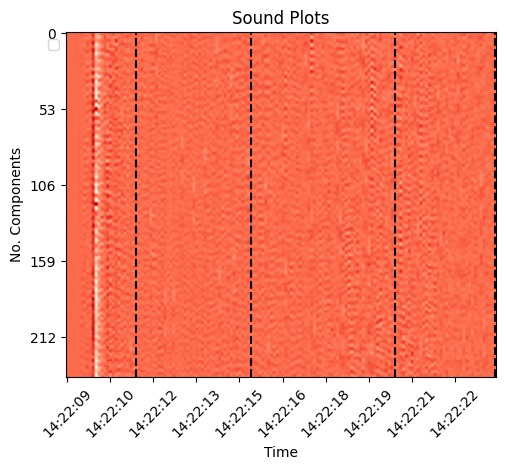

In [126]:
#                                                       TRAINING PLOT WITH TRANSITIONS

out = find_last_index(train_y1)
fig, ax = plt.subplots()
im = ax.imshow(train_audio1.T,cmap='Reds',aspect=0.5)

ax.axvline(x=out[0],color='black',linestyle='--')
ax.axvline(x=out[1],color='black',linestyle='--')
ax.axvline(x=out[2],color='black',linestyle='--')
ax.axvline(x=out[3],color='black',linestyle='--')

# Set the x-axis range to be in the 'sound_dt' time axis
x_ticks = range(len(train_dt1))
x_labels = [dt.strftime('%H:%M:%S') for dt in train_dt1]

# Add labels and title
plt.ylabel("No. Components")
plt.xlabel('Time')
plt.title("Sound Plots")

# Set the x-axis ticks and labels
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, rotation=45)  # You can adjust the rotation angle as needed

# Optionally, you can adjust the spacing between ticks for better readability
ax.xaxis.set_major_locator(plt.MaxNLocator(10))

# Set the y-axis range and labels (adjust as needed)
y_ticks = np.arange(0, len(train_audio1.T), 53)
y_labels = y_ticks
# Set the y-axis ticks and labels
ax.set_yticks(y_ticks)

plt.legend(loc='upper right', bbox_to_anchor=(0.0, 1.0))
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


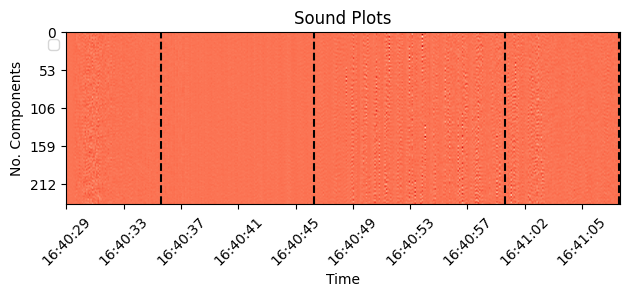

In [127]:
#                                                       TESTING PLOT WITH TRANSITIONS

out = find_last_index(test_y1)
fig, ax = plt.subplots()
im = ax.imshow(test_audio1.T,cmap='Reds',aspect=0.5)

ax.axvline(x=out[0],color='black',linestyle='--')
ax.axvline(x=out[1],color='black',linestyle='--')
ax.axvline(x=out[2],color='black',linestyle='--')
ax.axvline(x=out[3],color='black',linestyle='--')

# Set the x-axis range to be in the 'sound_dt' time axis
x_ticks = range(len(test_dt1))
x_labels = [dt.strftime('%H:%M:%S') for dt in test_dt1]

# Add labels and title
plt.ylabel("No. Components")
plt.xlabel('Time')
plt.title("Sound Plots")

# Set the x-axis ticks and labels
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, rotation=45)  # You can adjust the rotation angle as needed


# Set the y-axis range and labels (adjust as needed)
y_ticks = np.arange(0, len(test_audio1.T), 53)
y_labels = y_ticks
# Set the y-axis ticks and labels
ax.set_yticks(y_ticks)

# Optionally, you can adjust the spacing between ticks for better readability
ax.xaxis.set_major_locator(plt.MaxNLocator(10))

plt.legend(loc='upper right', bbox_to_anchor=(0.0, 1.0))
plt.tight_layout()
plt.show()

In [128]:
#                                                        ERROR PLOTTINGS
def abs_error(y,pred):
    y = np.array(y)
    pred = np.array(pred)
    dif = abs(y-pred)

    return dif

<Figure size 500x500 with 0 Axes>

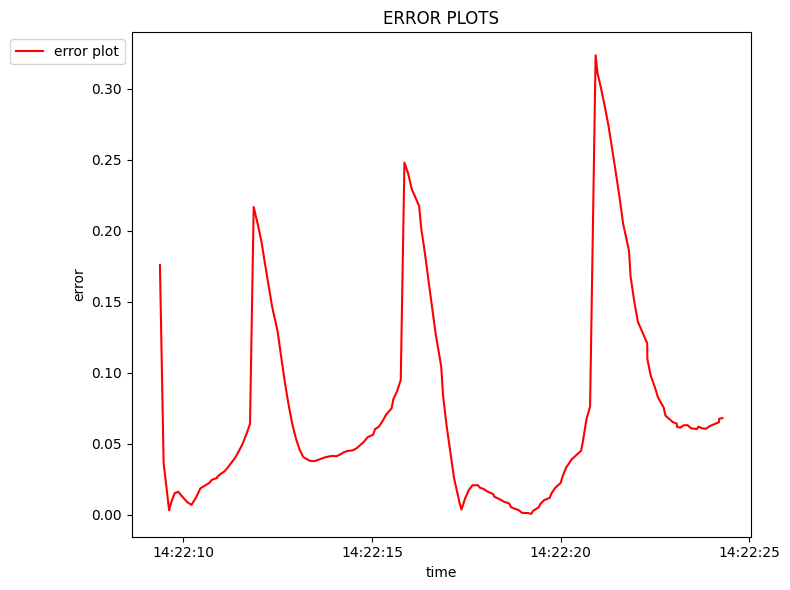

In [129]:
train1_error = abs_error(train_y1,train_out1)
plt.figure(figsize=(5, 5))

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(train_dt1,train1_error,color='red',label='error plot')

plt.ylabel("error")
plt.xlabel('time')
plt.title("ERROR PLOTS")

plt.legend(loc='upper right', bbox_to_anchor=(0.0, 1.0))
plt.tight_layout()
plt.show()

<Figure size 500x500 with 0 Axes>

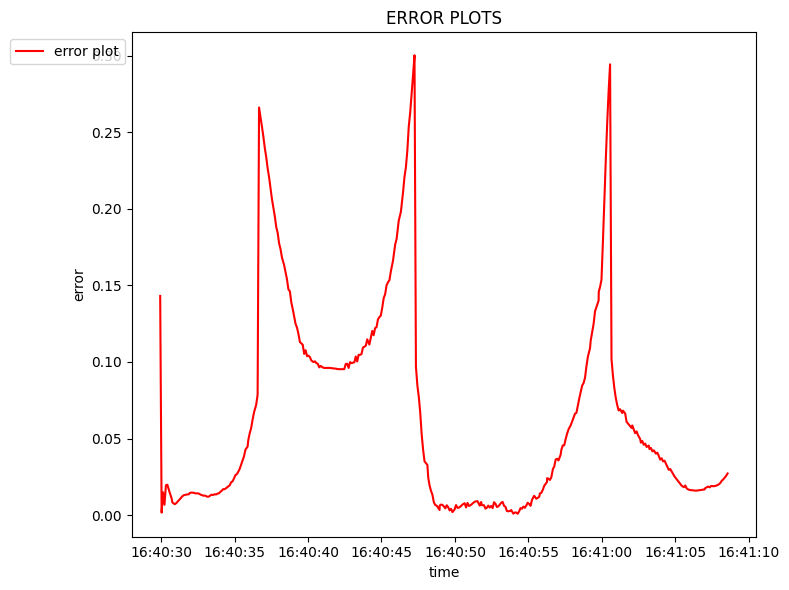

In [130]:
test1_error = abs_error(test_y1,test_out1)
plt.figure(figsize=(5, 5))

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(test_dt1,test1_error,color='red',label='error plot')

plt.ylabel("error")
plt.xlabel('time')
plt.title("ERROR PLOTS")

plt.legend(loc='upper right', bbox_to_anchor=(0.0, 1.0))
plt.tight_layout()
plt.show()

In [136]:
#                                                          Mean Absolute ERROR METRICS
train_mae = mean_absolute_error(train_y1,train_out1)
test_mae = mean_absolute_error(test_y1,test_out1)
val_mae = mean_absolute_error(val_y1,val_out1)


print("Train MAE: ",train_mae)
print("Test MAE: ",test_mae)
print("Val MAE: ",val_mae)

Train MAE:  0.07563553
Test MAE:  0.0658012
Val MAE:  0.07435634


In [137]:
#                                                            Mean Squared Error Metrics
train_mse = mean_squared_error(train_y1,train_out1)
test_mse = mean_squared_error(test_y1,test_out1)
val_mse = mean_squared_error(val_y1,val_out1)

print("Train MSE: ",train_mse)
print("Test MSE: ",test_mse)
print("Val MSE: ",val_mse)

Train MSE:  0.011305858
Test MSE:  0.008987759
Val MSE:  0.013405553


In [138]:
#                                                             R2 score Metrics
train_r2 = r2_score(train_y1,train_out1)
test_r2 = r2_score(test_y1,test_out1)
val_r2 = r2_score(val_y1,val_out1)

print("Train R2 score: ",train_r2)
print("Test R2 score: ",test_r2)
print("val_r2 score: ",val_r2)

Train R2 score:  0.6562419715869927
Test R2 score:  0.7658040329242896
val_r2 score:  0.5644755227302956


: 